# **Hate Speech and Offensive Content Detection**

## **1. Business Understanding**
### *Overview*
In Kenya's digital landscape, Twitter plays a critical role in shaping public discourse, especially during election seasons and politically charged events. While it provides a platform for civic engagement, it also facilitates the spread of hate speech, tribalism, and inciting language. This content can escalate tensions and contribute to real-world conflict if left unchecked.
### *Challenges*
Manually moderating large volumes of tweets is inefficient and prone to bias. Current moderation systems struggle to scale and often miss localized forms of hate speech, particularly those specific to Kenyan cultural and political contexts. There is also a lack of automated tools specifically designed to detect offensive content within Kenyan tweets.
### *Proposed Solution*
Develop a machine learning model that can automatically categorize tweets into three classes: hate speech, offensive content, or neither. The model will serve as a content flagging tool for:
Early detection of harmful tweets during elections or national events.
Support for content moderation teams at media outlets, regulatory bodies, and social platforms.
Enhancing digital safety by tracking the evolution and spread of dangerous speech trends.


An effective classification model tailored to the Kenyan context can reduce the spread of inciting content and improve the quality of online public discourse. This system would be vital in promoting peace, especially during sensitive periods like elections.

### *Problem Statement*
There is an urgent need for a localized and scalable hate speech detection system to flag inciting and offensive tweets in Kenya, particularly during political periods where online speech can incite real-world unrest.

### *Objectives*
- To evaluate the most common terms or phrases used in inciting tweets.
- To build a multi-class classification model that labels tweets as hate speech, offensive, or neither.
- To evaluate model performance across different algorithms using accuracy.
- To Deploy the best performing model using Streamlit

## **2 Data Understanding**
The dataset used in this project, HateSpeech_Kenya.csv, was sourced from Kaggle, a well-known platform for sharing datasets and machine learning challenges. It contains approximately 48,000 tweets labeled for sentiment and hate speech, specifically focused on the Kenyan social and political context.
Key Features of the Data:
`tweet`: The raw text of the tweet . this forms the primary input for natural language processing and classification tasks.
`label`: The target variable, where 0 represents neutral content and 1 represents offensive content and 2 represent hate speech.

This dataset is directly aligned with the project goal of developing a machine learning model to detect and categorize hate speech in Kenyan tweets. The inclusion of localized language, real-world offensive content, and metadata allows the model to learn patterns specific to the Kenyan context.


### *Importing Dependencies*

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Text Preprocessing
import re
import string

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk import FreqDist
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Filter Warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **3 Data Preparation**


In [2]:
# Loading the dataset, Mapping Class with respective Labels
df = pd.read_csv('HateSpeech_Kenya.csv')
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else x)
label_map = {0: 'Neutral', 1: 'Offensive', 2: 'Hate Speech'}
df['Label'] = df['Class'].map(label_map)
df.tail()


,hate_speech,offensive_language,neither,Class,Tweet,Label
48071,0,0,2,0,This is exactly what Moses Kuria & ilk are doi...,Neutral
48072,0,0,2,0,This is exactly what Kenyans are going through...,Neutral
48073,0,0,2,0,This is exactly what is wrong with this countr...,Neutral
48074,1,0,2,0,This is exactly the same thing. Well the only ...,Neutral
48075,0,1,2,0,This is exactly how Luos feel in this country ...,Neutral


### *Extracting the Relevant Columns*

In [3]:
new_df = df[['Tweet', 'Class', 'Label']]
new_df.head()

,Tweet,Class,Label
0,The political elite are in desperation. Ordina...,0,Neutral
1,Am just curious the only people who are callin...,0,Neutral
2,USERNAME_3 the area politicians are the one to...,0,Neutral
3,War expected in Nakuru if something is not don...,0,Neutral
4,USERNAME_4 tells kikuyus activists that they a...,0,Neutral


### *Dataset Summary*

In [4]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48076 entries, 0 to 48075
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   48076 non-null  object
 1   Class   48076 non-null  int64 
 2   Label   48076 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


### *Checking for Duplicates*

In [5]:
new_df.duplicated().sum()  # Check for duplicates (entire DataFrame)

0

In [6]:
new_df.drop_duplicates(inplace=True)  # Drop duplicates

### *Feature Engineering*

In [7]:
# creating columns for number of characters, number of sentences and number of words
new_df["char"]=new_df["Tweet"].apply(lambda x:len(x))
new_df["words"]=new_df["Tweet"].apply(lambda x:nltk.word_tokenize(x)).apply(lambda x:len(x))
new_df["sentences"]=new_df["Tweet"].apply(lambda x:nltk.sent_tokenize(x)).apply(lambda x:len(x))
new_df.sample(10)

,Tweet,Class,Label,char,words,sentences
12578,WOLD LEADERS HAVE NOT FREED TIBET #CallBankofC...,0,Neutral,264,36,1
47744,This pic represents well how kalenjins are fol...,0,Neutral,71,11,1
46905,Trends Judiciary Supreme Court Chief Justice M...,0,Neutral,127,17,1
26373,warudi kwao team mafisi wanakula na kuachilia tu,1,Offensive,48,8,1
38352,Kikuyus are trending for whatever reason exact...,0,Neutral,103,19,1
20980,This is Masielo AP camp in Bumula constituency...,0,Neutral,138,18,2
25257,Bcoz ur men R dying of cheap liquor and you wa...,2,Hate Speech,140,29,2
22874,We have never heard such from Central it means...,2,Hate Speech,103,20,2
42388,Without Prejudice. Some guys are beyond redemp...,0,Neutral,109,20,4
11656,You are a great leader I respect your views an...,0,Neutral,129,23,2


### *Summary Statistics*

In [8]:
new_df.describe()

,Class,char,words,sentences
count,48076.000000,48076.000000,48076.000000,48076.000000
mean,0.310030,110.663637,20.334054,1.798174
std,0.588431,48.989947,9.505972,0.991620
min,0.000000,1.000000,1.000000,1.000000
25%,0.000000,79.000000,14.000000,1.000000
50%,0.000000,111.000000,20.000000,2.000000
75%,0.000000,135.000000,25.000000,2.000000
max,2.000000,327.000000,68.000000,14.000000


### *Check Target Values*

In [9]:
features = ['Class', 'Label']
for feature in features:
    print(f"Unique values in {feature}: {new_df[feature].unique()}")

Unique values in Class: [0 1 2]
Unique values in Label: ['Neutral' 'Offensive' 'Hate Speech']


### *Text Cleaning*

Raw tweets often contain noise such as:
- URLs
- Mentions
- Hashtags
- Emojis and non-alphanumeric characters

We'll apply basic text preprocessing to clean the tweet data.


In [10]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    item = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags 
    item = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alphabetic
    text = text.lower().strip()             # convert to lowercase and strip whitespace
    return text

new_df['Clean_Tweet'] = new_df['Tweet'].apply(clean_text)
new_df.head()

,Tweet,Class,Label,char,words,sentences,Clean_Tweet
0,The political elite are in desperation. Ordina...,0,Neutral,93,14,2,the political elite are in desperation ordinar...
1,Am just curious the only people who are callin...,0,Neutral,138,26,1,am just curious the only people who are callin...
2,USERNAME_3 the area politicians are the one to...,0,Neutral,132,22,1,username the area politicians are the one to b...
3,War expected in Nakuru if something is not don...,0,Neutral,112,23,3,war expected in nakuru if something is not don...
4,USERNAME_4 tells kikuyus activists that they a...,0,Neutral,120,21,3,username tells kikuyus activists that they are...


### EDA

We'll visualize class distribution, tweet lengths, and word frequencies to better understand the dataset.

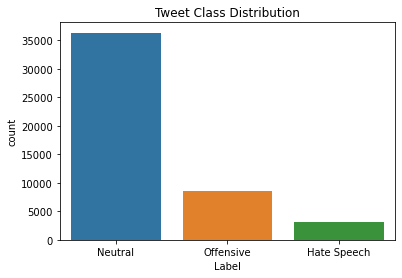

In [11]:
# Class distribution
sns.countplot(data=new_df, x='Label')
plt.title('Tweet Class Distribution')
plt.show()


### Box plot of the distribution of number of characters accross classes/label

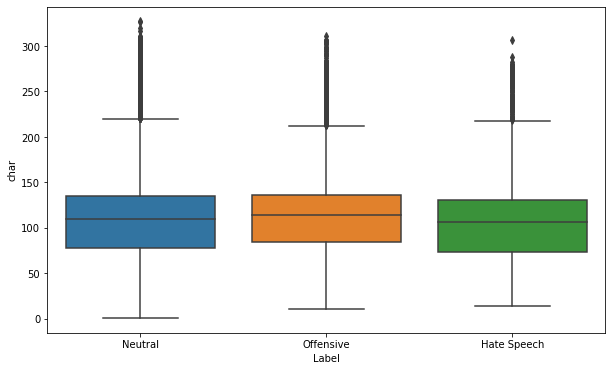

In [25]:

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=new_df,
    x='Label',               
    y='char') 
            
plt.title='Character Count Distribution by Label'
plt.xlabel='Label',
plt.ylabel='Number of Characters'
plt.show()



### Box plot of the distribution of number of words accross classes/label

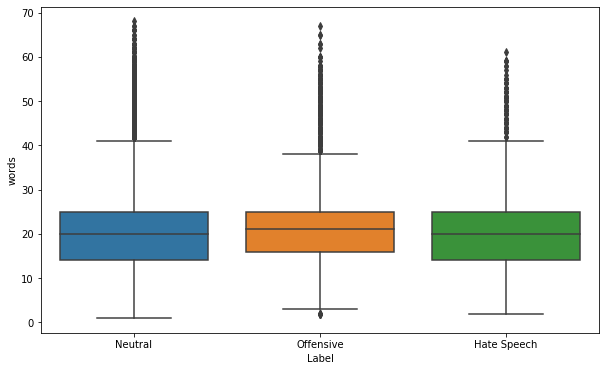

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=new_df,
    x='Label',               
    y='words') 
            
plt.title='Character Count Distribution by Label'
plt.xlabel='Label',
plt.ylabel='Number of Words'
plt.show()

### Box plot of the distribution of number of sentences accross classes/label

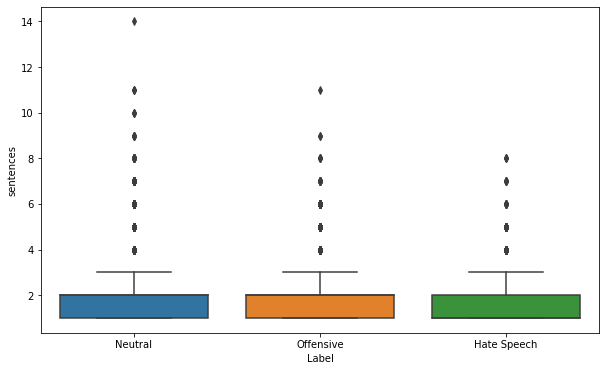

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=new_df,
    x='Label',               
    y='sentences') 
            
plt.title='Character Count Distribution by Label'
plt.xlabel='Label',
plt.ylabel='Number of Sentences'
plt.show()

### Text preprocessing
Tokenizzing , selecting words with 3 or more characters, removing stop words

In [26]:
# Tokenizer that uses a regex pattern to select words with three or more characters
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")

# List of stopwords in English
english_stopwords = stopwords.words('english')
swahili_stopwords = [
    "a", "na", "ya", "kwa", "wa", "ni", "la", "ili", "katika", "juu", "chini", "kama", "pia", "hadi", "toka",
    "lakini", "kwamba", "hata", "bado", "baada", "mbele", "nyuma", "tu", "tena", "sana", "zote", "wote", "sisi",
    "wao", "wewe", "mimi", "yeye", "huu", "hii", "hawa", "hao", "hizo", "wale", "wetu", "wako", "wangu", "hivyo",
    "au", "kuwa", "ame", "alikuwa", "walikuwa", "si", "ha", "ambapo", "kwani", "ndio", "bila", "kila", "baadhi",
    "mara", "zaidi", "kati", "kupitia"]

sheng_stopwords = [
    "ati", "ajee", "aje", "manze", "yani", "venye", "vile", "niko", "uko", "ako", "nko", "si", "ni", "kaa",
    "hivo", "ivo", "ngori", "ebu", "ah", "lo", "aa", "maze", "fiti", "dem", "boyie", "wasee", "mabeshte", "buda",
    "brathe", "msee", "mresh", "jamaa", "bro", "sis", "sanaa", "kweli", "freshi", "mbogi", "hadi", "balaa",
    "noma", "walai", "ju", "ama", "bado", "mbaya", "vile", "nani", "kitu", "place", "hio", "hiyo", "hii", "ile",
    "nyinyi", "sisi", "mimi", "wewe", "wao", "yeye"
]

# Combine all stopwords list
stopwords_list = set(english_stopwords + swahili_stopwords + sheng_stopwords)

# Use Lemmatizer
lemmatizer = WordNetLemmatizer()

In [27]:
def preprocess_text(text, tokenizer, stopwords_list, lemmatizer):
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    words = [word for word in tokens if word not in stopwords_list]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

### Performing preprocessing on the clean tweet feature


In [28]:
text_data = new_df['Clean_Tweet'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, lemmatizer))
text_data.tail()

48071    [exactly, moses, kuria, ilk, say, negative, et...
48072    [exactly, kenyan, going, thank, god, time, ric...
48073    [exactly, wrong, country, kikuyus, cant, stand...
48074    [exactly, thing, well, difference, kilifi, the...
48075    [exactly, luo, feel, country, like, moses, kur...
Name: Clean_Tweet, dtype: object

### Adding preprocessed tweet as a column

In [29]:
new_df["Preprocessed_Tweet"] = text_data
new_df.head()

,Tweet,Class,Label,char,words,sentences,Clean_Tweet,Preprocessed_Tweet
0,The political elite are in desperation. Ordina...,0,Neutral,93,14,2,the political elite are in desperation ordinar...,"[political, elite, desperation, ordinary, kale..."
1,Am just curious the only people who are callin...,0,Neutral,138,26,1,am just curious the only people who are callin...,"[curious, people, calling, old, mad, kikuyus, ..."
2,USERNAME_3 the area politicians are the one to...,0,Neutral,132,22,1,username the area politicians are the one to b...,"[username, area, politician, one, blame, coz, ..."
3,War expected in Nakuru if something is not don...,0,Neutral,112,23,3,war expected in nakuru if something is not don...,"[war, expected, nakuru, something, done, luo, ..."
4,USERNAME_4 tells kikuyus activists that they a...,0,Neutral,120,21,3,username tells kikuyus activists that they are...,"[username, tell, kikuyus, activist, targeted, ..."


### Frequency Dist Of Preprocessed Words

In [30]:
frequency_dist = FreqDist(new_df['Preprocessed_Tweet'].explode())
frequency_dist

FreqDist({'username': 15522, 'kikuyus': 7361, 'luo': 5223, 'noreformsnoelections': 4032, 'nyakundi': 2933, 'kenya': 2855, 'people': 2672, 'kenyan': 2529, 'like': 2357, 'one': 2125, ...})

### Distribution of top 20 words 

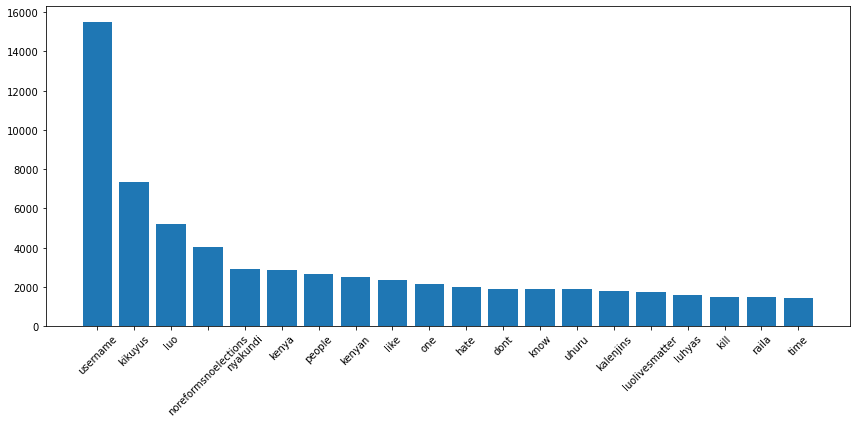

In [36]:

# Sort the dictionary by value (descending)
sorted_dict = dict(sorted(frequency_dist.items(), key=lambda x: x[1], reverse=True))

# Take the top 20 Words
top_20 = dict(list(sorted_dict.items())[:20])

keys = [str(k) for k in top_20.keys()]
values =  list( top_20.values())

plt.figure(figsize=(12, 6))
plt.bar(top_20.keys(), top_20.values())
plt.title=("Distribution of top 20 Words in Tweets")
plt.xlabel=("Words")
plt.ylabel=("Count")
plt.xticks(rotation=45)  

plt.tight_layout()  
plt.show()

## Word Cloud PLot
# from wordcloud import WordCloud

### Getting rid of the word "username"

In [58]:
new_df["Clean_Tweet"] = new_df["Clean_Tweet"].str.replace("username", "", regex=False).str.strip()
  

In [60]:
text_data = new_df['Clean_Tweet'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, lemmatizer))
new_df["Preprocessed_Tweet"] = text_data
new_df.head()

,Tweet,Class,Label,char,words,sentences,Clean_Tweet,Preprocessed_Tweet
0,The political elite are in desperation. Ordina...,0,Neutral,93,14,2,the political elite are in desperation ordinar...,"[political, elite, desperation, ordinary, kale..."
1,Am just curious the only people who are callin...,0,Neutral,138,26,1,am just curious the only people who are callin...,"[curious, people, calling, old, mad, kikuyus, ..."
2,USERNAME_3 the area politicians are the one to...,0,Neutral,132,22,1,the area politicians are the one to blame coz ...,"[area, politician, one, blame, coz, insiting, ..."
3,War expected in Nakuru if something is not don...,0,Neutral,112,23,3,war expected in nakuru if something is not don...,"[war, expected, nakuru, something, done, luo, ..."
4,USERNAME_4 tells kikuyus activists that they a...,0,Neutral,120,21,3,tells kikuyus activists that they are being ta...,"[tell, kikuyus, activist, targeted, targetted,..."


### Distribution of Words by LABEL/CLASS

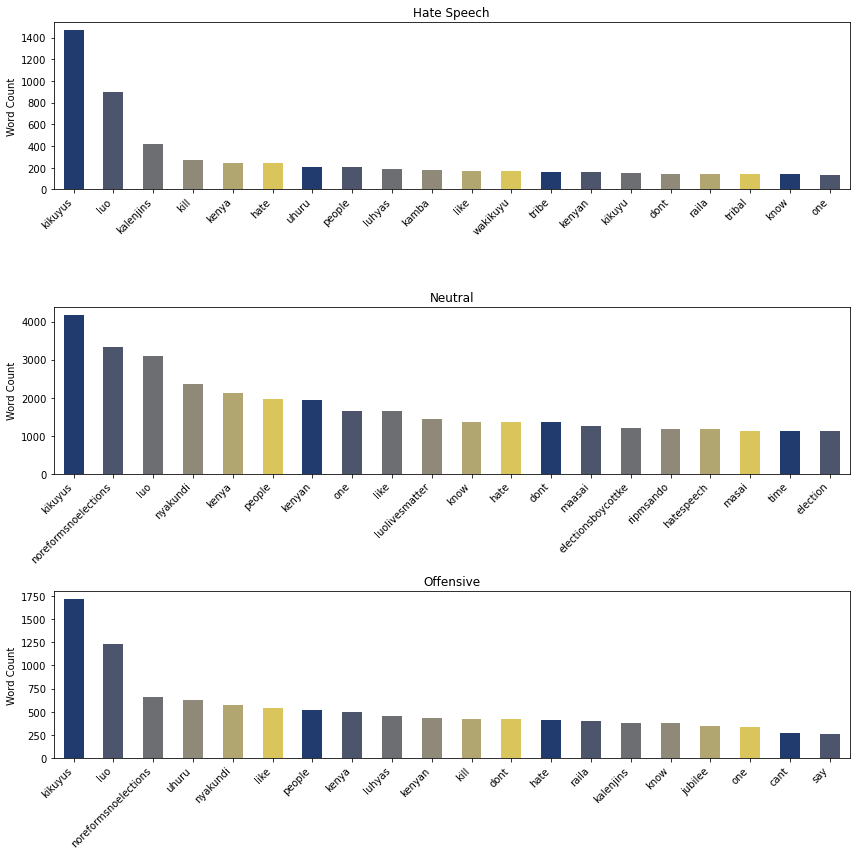

In [67]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 12))
color_palette = sns.color_palette('cividis')  # Unlimited colors from palette

for idx, label_df in enumerate(new_df.groupby('Label')):
    label_name, group_data = label_df
    all_words = group_data['Preprocessed_Tweet'].explode()
    top_20 = all_words.value_counts().nlargest(20)
    
    # Plot with automatic color cycling
    ax = axes[idx]
    top_20.plot.bar(ax=ax, color=color_palette)
    ax.set_title(label_name.title())
    ax.set_xticklabels(top_20.index, rotation=45, ha='right')
    ax.set_ylabel('Word Count')

fig.tight_layout()
plt.show()

### Word Cloud

In [73]:
#pip install wordcloud

In [79]:
from wordcloud import WordCloud

# List of sentiment classes (ensure they match the values in your DataFrame exactly)
sentiments = ['Neutral', 'Offensive', 'Hate Speech']

# Set figure size for vertical layout
plt.figure(figsize=(10, 15))

# Generate and plot word cloud for each sentiment
for i, sentiment in enumerate(sentiments, 1):
    text = " ".join(
        new_df[new_df['Label'].str.lower() == sentiment].astype(str)
    )

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='viridis',
        max_words=200
    ).generate(text)

    # Plot in a separate row
    plt.subplot(3, 1, i)  
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"{sentiment.capitalize()} Tweets", fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

AttributeError: 'TransposedFont' object has no attribute 'getbbox'

<Figure size 720x1080 with 0 Axes>